## author : Meigui Yu
## date : 2017-7-27
## I am using python 2.7.x in this project.

######project background############
# Zillow is an online real estate database company that was founded in 2006.
# In this project, Zillow aims to predict the log-error between their Zestimate and the actual sale price,
# given all the features of a home.

# We get three datasets:
# properties_2016.csv - all the properties with their home features for 2016.
# train_2016.csv - the training set with transactions from 1/1/2016 to 12/31/2016
# sample_submission.csv - a sample submission file in the correct format

# The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
# We need to predict 6 time points for all properties:
# October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).
########################################
########################################
########################################


## Version 1:
## Filler the features that contain less than 25% missing values as train dataset.
## Creat new additional features.
## Data visualization to evaluate the correlations of the variables.
## Using lightbgm to build model.

## Version 2:
## params = {}
##　params['learning_rate'] = 0.03
##　params['max_depth'] = 6
##　params['boosting_type'] = 'gbdt'
##　params['objective'] = 'regression'
##　params['metric'] = 'auc'
##　params['sub_feature'] = 0.5
##　params['num_leaves'] = 64
##　params['min_data'] = 500
##　params['min_hessian'] = 1
##　watchlist = [d_valid]
##　clf = lgb.train(params, d_train, 1000, watchlist)


## Version 3:
## Calculate the MAE for lightGBM after prediction 
##　logReal=x_valid.logerror
##　del x_test; gc.collect()
##　maelgh=mean_absolute_error(logReal, p_test)
##　print("##########")
##　print("CV: MAE for LIGHTGBM is", maelgh)
##　print("##########")


## Version ４:
## params = {}
##　params = {}
##　params['max_bin'] = 10
##　params['learning_rate'] = 0.0021 # shrinkage_rate
##　params['boosting_type'] = 'gbdt'
##　params['objective'] = 'regression'
##　params['metric'] = 'l1'          # or 'mae'
##　params['sub_feature'] = 0.3      # feature_fraction (small values => use very different submodels)
##　params['bagging_fraction'] = 0.85 # sub_row
##　params['bagging_freq'] = 40
##　params['num_leaves'] = 512        # num_leaf
##　params['min_data'] = 500         # min_data_in_leaf
##　params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
##　params['verbose'] = 0
##　params['feature_fraction_seed'] = 2
##　params['bagging_seed'] = 3
##　watchlist = [d_valid]
##　clf = lgb.train(params, d_train, 430, watchlist)

## Version ４:
## Calculate the accuracy score and auc value.


In [3]:
import numpy as np        # linear algebra
import pandas as pd       # data processing, CSV file I/O (e.g. pd.read_csv())
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns       # data visualization
color = sns.color_palette()
sns.set_style('whitegrid')
import lightgbm as lgb
import gc
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


In [4]:
## load the train_2016_v2 dataset
train_df = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'])
print('Loading train_2016 dataset...')
print('Train_2016 dataset shape: ')
print(train_df.shape)
print('The first few rows of train_2016 dataset : ')
print(train_df.head())
print('Summary of train_2016 dataset : ')
print(train_df.describe())
train_df_null = train_df.isnull().sum()
print('The ratio of missing values in each column : ')    # the training data looks fine, there is no missing data
print(train_df_null/train_df.shape[0])


Loading train_2016 dataset...
Train_2016 dataset shape: 
(90275, 3)
The first few rows of train_2016 dataset : 
   parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02
Summary of train_2016 dataset : 
           parcelid      logerror
count  9.027500e+04  90275.000000
mean   1.298466e+07      0.011457
std    2.504510e+06      0.161079
min    1.071174e+07     -4.605000
25%    1.155950e+07     -0.025300
50%    1.254734e+07      0.006000
75%    1.422755e+07      0.039200
max    1.629608e+08      4.737000
The ratio of missing values in each column : 
parcelid           0.0
logerror           0.0
transactiondate    0.0
dtype: float64


F:\Anaconda3\envs\gl-env\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
F:\Anaconda3\envs\gl-env\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


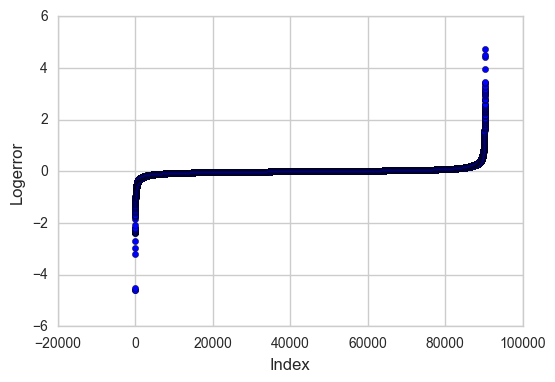

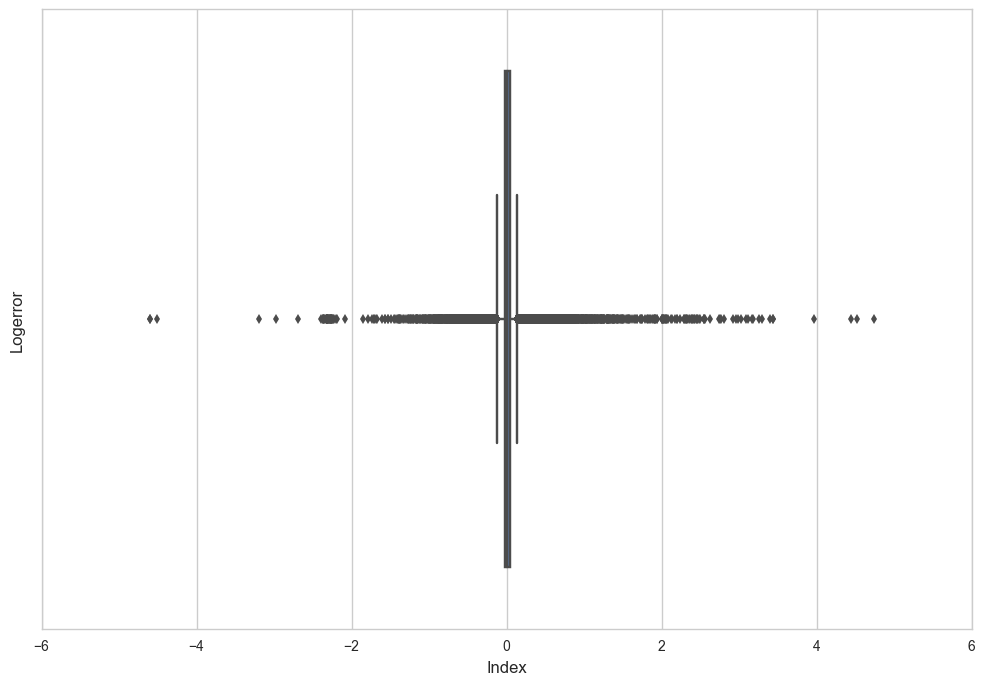

In [5]:
## now let's do some visualizaion on the training dataset
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()
# We couldn't decide the outliers in the above scatter plot. So let's plot the boxplot to see how much outliers it contains.
plt.figure(figsize=(12,8))
sns.boxplot(x=np.sort(train_df.logerror.values), data=train_df)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()
## Obviously, we need to remove some logerror outliers in order to see the three quantiles.



F:\Anaconda3\envs\gl-env\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


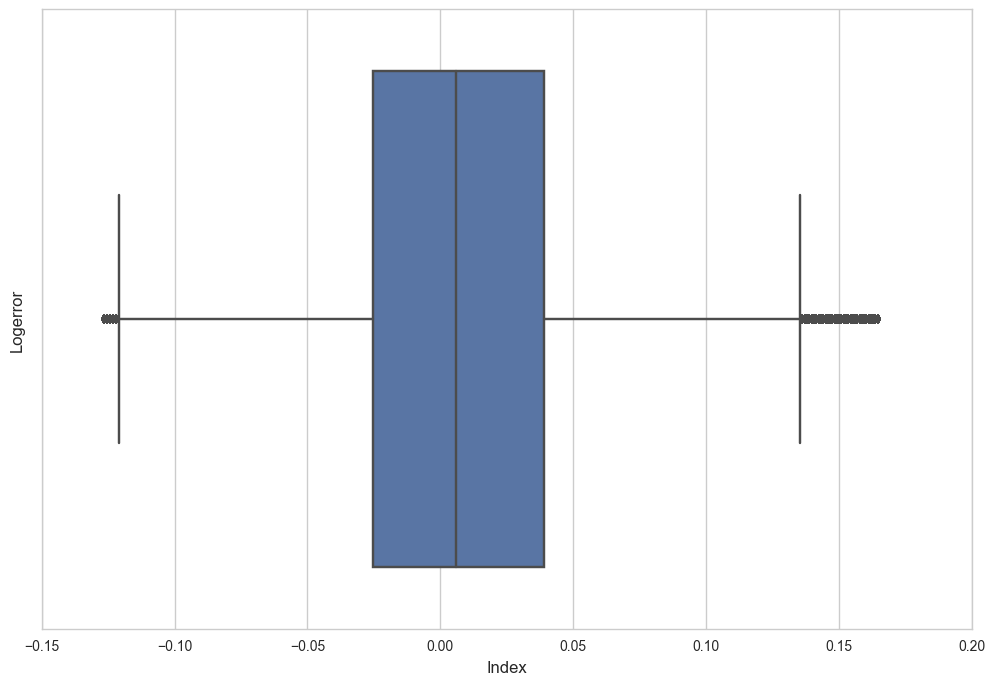

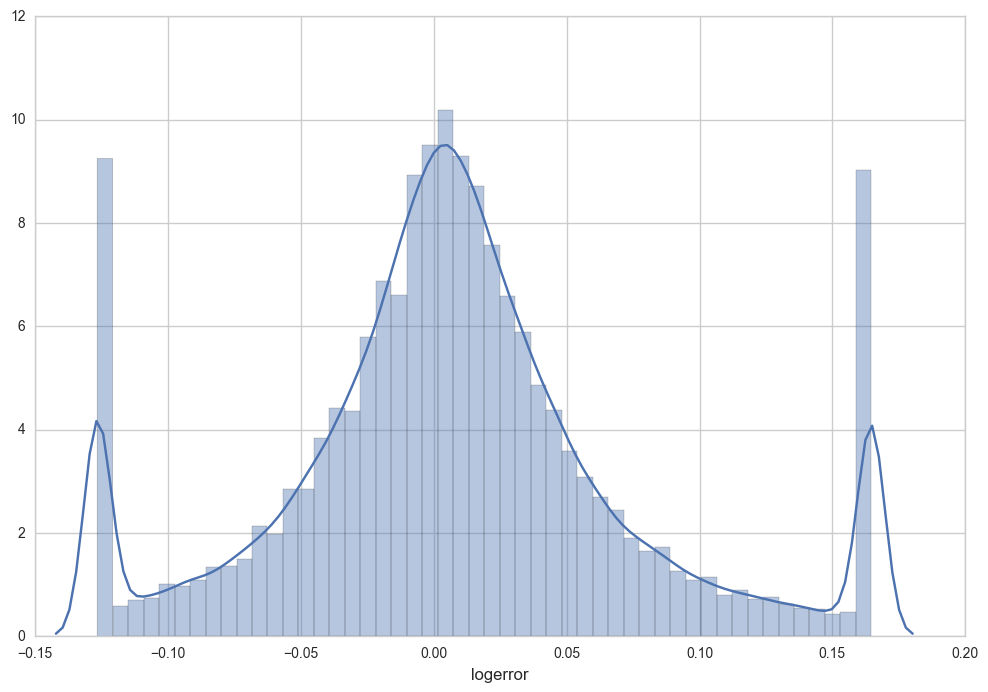

In [6]:
## remove the outliers and do a histogram plot of 'logerror'
ulimit = np.percentile(train_df.logerror.values, 95) #select the 99th value of logerror
llimit = np.percentile(train_df.logerror.values, 5)  ##select the 1st value of logerror
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit #replace the value that greater than ulimit to ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit ##replace the value that less than llimit to llimit
plt.figure(figsize=(12,8))
sns.boxplot(x=train_df.logerror.values)
# sns.swarmplot(x=train_df.logerror.values)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50) #distribution plot
plt.xlabel('logerror', fontsize=12)
plt.show()
## I am not sure if we could keep the outliers while we built the predictive model. So I will try one with logerror outliers and one without outliers.



F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


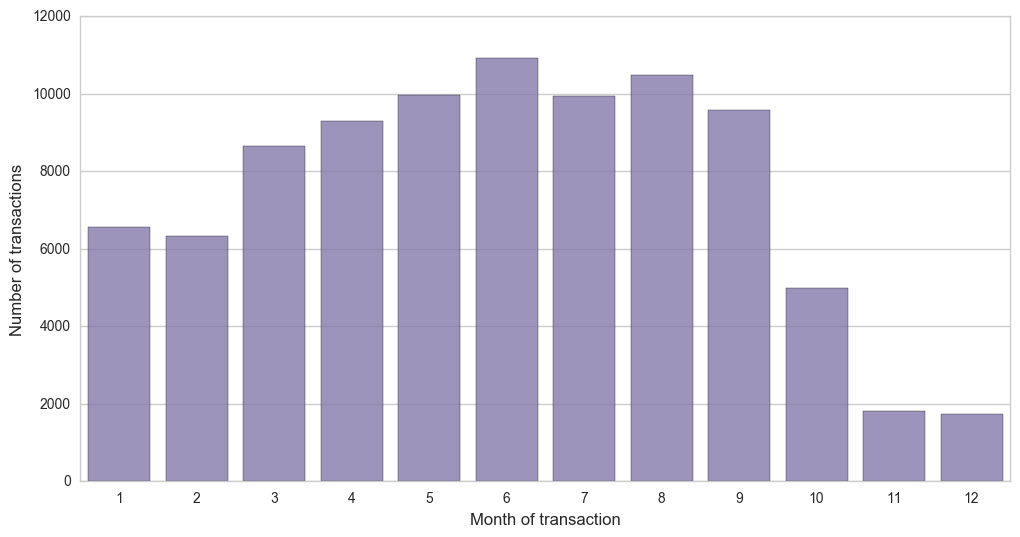

In [7]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month
tm_cnt = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(tm_cnt.index, tm_cnt.values, alpha=0.8, color=color[3]) #plot each month's transaction
# plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)
plt.show()


In [8]:
## The last variable in the training dataset is parcelid. I guess the parcelid is the unique key.
## Let's examine by counting the number of unique values.
print('The number of unique parcelid : ')
print(train_df['parcelid'].value_counts().reset_index()['parcelid'].value_counts())
## Our estimation is correct. Though there are 124 parcelid appear more than once, alomost all of them appear only once.
## So we can take parcelid as a unique key.


The number of unique parcelid : 
1    90026
2      123
3        1
Name: parcelid, dtype: int64


In [9]:
## Then let's explore the properties_2016 dataset.
property_df = pd.read_csv('properties_2016.csv')
print('Loading properties_2016 dataset...')
print('The properties_2016 dataset shape : ')
print(property_df.shape)
print('The first few rows of properties_2016 dataset : ')
print(property_df.head())
print('Summary of properties_2016 dataset : ')
print(property_df.describe())
property_df_null = property_df.isnull().sum()
print('The ratio of missing values in each column : ')
print(property_df_null/property_df.shape[0])
## We can see that they both have parcelid in their dataset. Butthe properties file has much larger data amount than the traning dataset.
## So we need to merger these two dataset before carrying out our analysis.


F:\Anaconda3\envs\gl-env\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading properties_2016 dataset...
The properties_2016 dataset shape : 
(2985217, 58)
The first few rows of properties_2016 dataset : 
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  10754147                    NaN                       NaN           NaN   
1  10759547                    NaN                       NaN           NaN   
2  10843547                    NaN                       NaN           NaN   
3  10859147                    NaN                       NaN           NaN   
4  10879947                    NaN                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          0.0         0.0                  NaN                    NaN   
1          0.0         0.0                  NaN                    NaN   
2          0.0         0.0                  NaN                    NaN   
3          0.0         0.0                  3.0                    7.0   
4          0.0         0.0

In [10]:
merge_df = pd.merge(train_df, property_df, on='parcelid', how='left')
print('Data merging...')
print('The shape of merged dataset : ')
print(merge_df.shape)
print('The first few rows of merged dataset : ')
print(merge_df.head())
print('Summary of merged dataset : ')
print(merge_df.describe())
merge_df_null = merge_df.isnull().sum(axis=0).reset_index()
merge_df_null.columns = ['column_name', 'missing_count']
merge_df_null['merge_null_ratio'] =  merge_df_null['missing_count']/merge_df.shape[0]
merge_df_null = merge_df_null.sort_values(by='merge_null_ratio')
print('The ratio of missing values in each column : ')
print(merge_df_null)

Data merging...
The shape of merged dataset : 
(90275, 61)
The first few rows of merged dataset : 
   parcelid  logerror transactiondate  transaction_month  \
0  11016594    0.0276      2016-01-01                  1   
1  14366692   -0.1267      2016-01-01                  1   
2  12098116   -0.0040      2016-01-01                  1   
3  12643413    0.0218      2016-01-02                  1   
4  14432541   -0.0050      2016-01-02                  1   

   airconditioningtypeid  architecturalstyletypeid  basementsqft  bathroomcnt  \
0                    1.0                       NaN           NaN          2.0   
1                    NaN                       NaN           NaN          3.5   
2                    1.0                       NaN           NaN          3.0   
3                    1.0                       NaN           NaN          2.0   
4                    NaN                       NaN           NaN          2.5   

   bedroomcnt  buildingclasstypeid         ...       

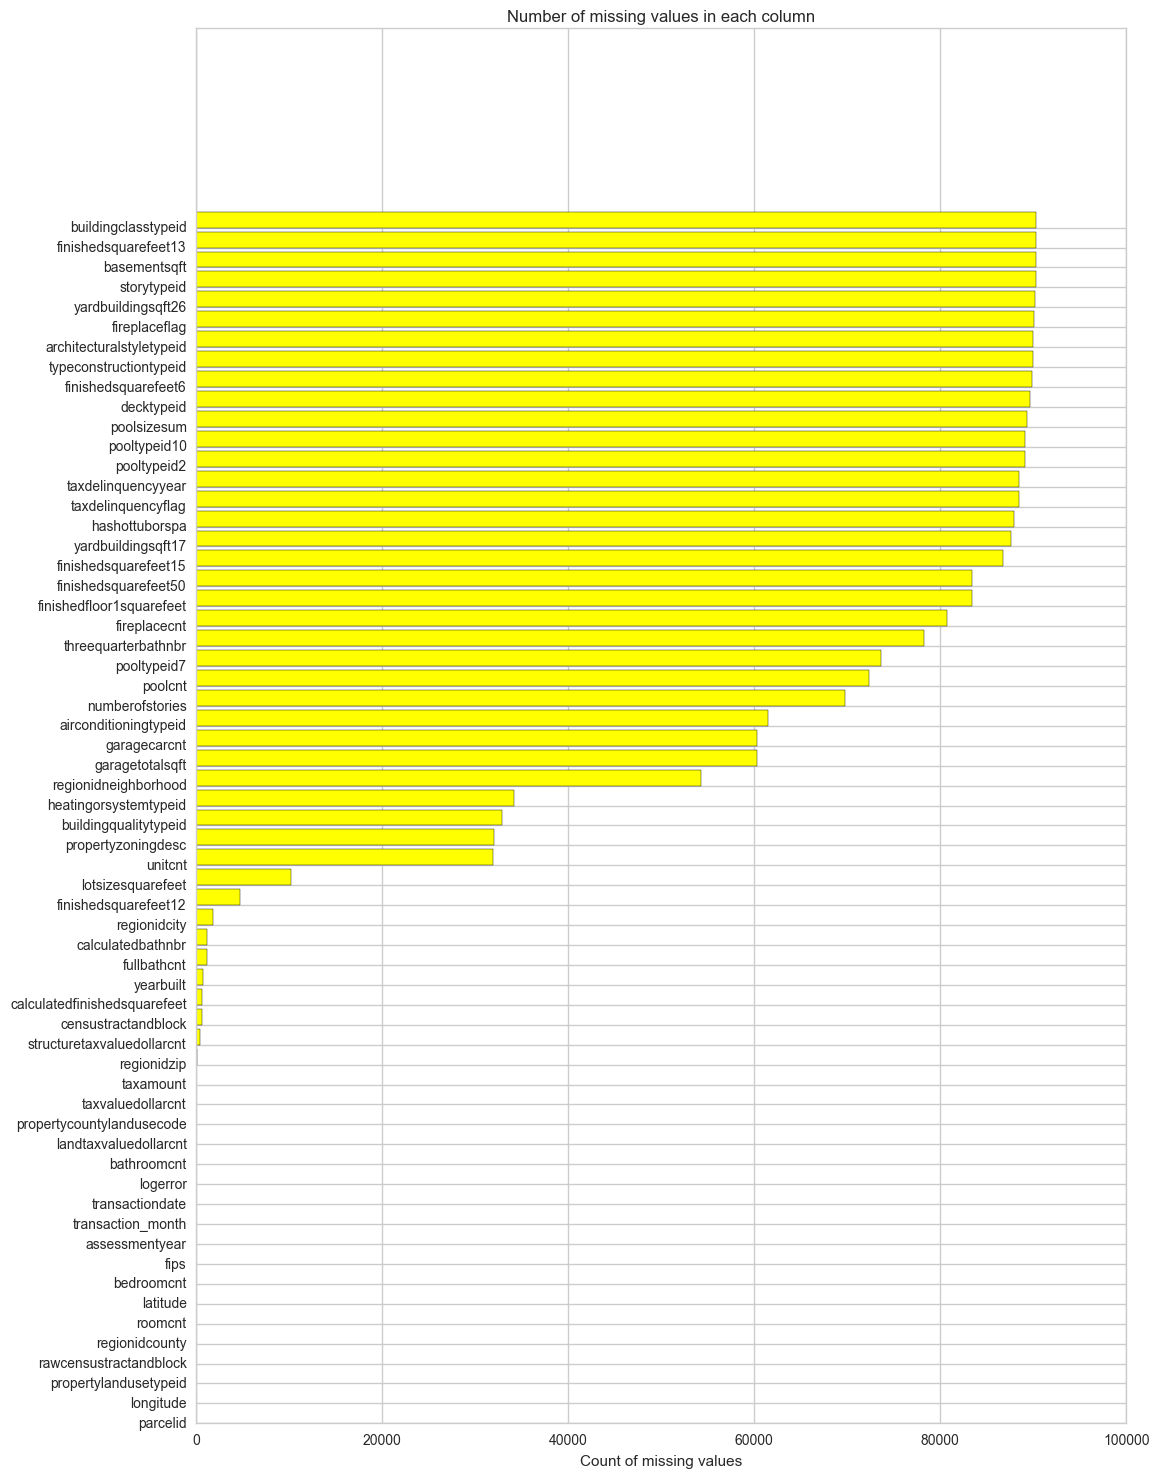

In [11]:
sns.set_style("whitegrid")
ind = np.arange(merge_df_null.shape[0]) #number of rows of missing_df
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, merge_df_null.missing_count.values, color='yellow') #horizontal bar plot, set the width as ind and fillin with missing_count.values
ax.set_yticks(ind)
ax.set_yticklabels(merge_df_null.column_name.values, rotation='horizontal') #plot the number of missing value in each column
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [12]:
merge_df_null = merge_df_null.ix[merge_df_null['merge_null_ratio']<0.2500]
print('Columns that contain less than 25% missing values : ')
print(merge_df_null)

Columns that contain less than 25% missing values : 
                     column_name  missing_count  merge_null_ratio
0                       parcelid              0          0.000000
28                     longitude              0          0.000000
36         propertylandusetypeid              0          0.000000
38        rawcensustractandblock              0          0.000000
40                regionidcounty              0          0.000000
43                       roomcnt              0          0.000000
27                      latitude              0          0.000000
8                     bedroomcnt              0          0.000000
20                          fips              0          0.000000
55                assessmentyear              0          0.000000
3              transaction_month              0          0.000000
2                transactiondate              0          0.000000
1                       logerror              0          0.000000
7                    ba

In [13]:
## let's remove those variables contain more than 75% missing values in merge_df
merge_df_new = pd.DataFrame()
columns = merge_df_null['column_name']
c_list = columns.tolist()
print(c_list)
length = len(c_list)
for i in range(0,length):
        print(c_list[i])
        merge_df_new[c_list[i]] = merge_df[c_list[i]]
# columns = merge_df_null.column_name.values
# merge_df_new = merge_df[columns]


['parcelid', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'latitude', 'bedroomcnt', 'fips', 'assessmentyear', 'transaction_month', 'transactiondate', 'logerror', 'bathroomcnt', 'landtaxvaluedollarcnt', 'propertycountylandusecode', 'taxvaluedollarcnt', 'taxamount', 'regionidzip', 'structuretaxvaluedollarcnt', 'censustractandblock', 'calculatedfinishedsquarefeet', 'yearbuilt', 'fullbathcnt', 'calculatedbathnbr', 'regionidcity', 'finishedsquarefeet12', 'lotsizesquarefeet']
parcelid
longitude
propertylandusetypeid
rawcensustractandblock
regionidcounty
roomcnt
latitude
bedroomcnt
fips
assessmentyear
transaction_month
transactiondate
logerror
bathroomcnt
landtaxvaluedollarcnt
propertycountylandusecode
taxvaluedollarcnt
taxamount
regionidzip
structuretaxvaluedollarcnt
censustractandblock
calculatedfinishedsquarefeet
yearbuilt
fullbathcnt
calculatedbathnbr
regionidcity
finishedsquarefeet12
lotsizesquarefeet


In [14]:
## more than 10 percent missing values, so we can deal with its missing value first and keep the other features unchagned.
mean_values = merge_df_new.mean(axis=0)
merge_df_new = merge_df_new.fillna(mean_values, inplace=True)
print(merge_df_new.shape)
print(merge_df_new.head())

(90275, 28)
   parcelid    longitude  propertylandusetypeid  rawcensustractandblock  \
0  11016594 -118488536.0                  261.0            6.037107e+07   
1  14366692 -117677556.0                  261.0            6.059052e+07   
2  12098116 -118175032.0                  261.0            6.037464e+07   
3  12643413 -118309000.0                  266.0            6.037296e+07   
4  14432541 -117700234.0                  261.0            6.059042e+07   

   regionidcounty  roomcnt    latitude  bedroomcnt    fips  assessmentyear  \
0          3101.0      0.0  34280990.0         3.0  6037.0          2015.0   
1          1286.0      0.0  33668120.0         4.0  6059.0          2015.0   
2          3101.0      0.0  34136312.0         2.0  6037.0          2015.0   
3          3101.0      0.0  33755800.0         2.0  6037.0          2015.0   
4          1286.0      8.0  33485643.0         4.0  6059.0          2015.0   

         ...          regionidzip structuretaxvaluedollarcnt  \
0   

In [15]:
## creating new features
merge_df_new["N-location"] = merge_df_new["latitude"] + merge_df_new["longitude"]
print('merge_df_new N-location : ' head(merge_df_new["N-location"]))
property_df["N-location"] = property_df["latitude"] + property_df["longitude"]
merge_df_new['N-LivingAreaProp'] = merge_df_new['calculatedfinishedsquarefeet']/merge_df_new['lotsizesquarefeet']
property_df['N-LivingAreaProp'] = property_df['calculatedfinishedsquarefeet']/property_df['lotsizesquarefeet']
## Ratio of tax of property over parcel
merge_df_new['N-ValueRatio'] = merge_df_new['taxvaluedollarcnt']/merge_df_new['taxamount']
property_df['N-ValueRatio'] = property_df['taxvaluedollarcnt']/property_df['taxamount']
## Ratio of the built structure value to land area
merge_df_new['N-ValueProp'] = merge_df_new['structuretaxvaluedollarcnt']/merge_df_new['landtaxvaluedollarcnt']
property_df['N-ValueProp'] = property_df['structuretaxvaluedollarcnt']/property_df['landtaxvaluedollarcnt']
## TotalTaxScore
merge_df_new['N-TaxScore'] = merge_df_new['taxvaluedollarcnt']*merge_df_new['taxamount']
property_df['N-TaxScore'] = property_df['taxvaluedollarcnt']*property_df['taxamount']
## Number of properties in the zip
zip_count = merge_df_new['regionidzip'].value_counts().to_dict()
zip_count_prop = property_df['regionidzip'].value_counts().to_dict()
merge_df_new['N-zip_count'] = merge_df_new['regionidzip'].map(zip_count)
property_df['N-zip_count'] = property_df['regionidzip'].map(zip_count_prop)
## Number of properties in the city
city_count = merge_df_new['regionidcity'].value_counts().to_dict()
city_count_prop = property_df['regionidcity'].value_counts().to_dict()
merge_df_new['N-city_count'] = merge_df_new['regionidcity'].map(city_count)
property_df['N-city_count'] = property_df['regionidcity'].map(city_count_prop)
## Average structuretaxvaluedollarcnt by city
group = merge_df_new.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
group_prop = property_df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merge_df_new['N-Avg-structuretaxvaluedollarcnt'] = merge_df_new['regionidcity'].map(group)
property_df['N-Avg-structuretaxvaluedollarcnt'] = property_df['regionidcity'].map(group_prop)
## Deviation away from average
merge_df_new['N-Dev-structuretaxvaluedollarcnt'] = abs((merge_df_new['structuretaxvaluedollarcnt'] - merge_df_new['N-Avg-structuretaxvaluedollarcnt']))/merge_df_new['N-Avg-structuretaxvaluedollarcnt']
property_df['N-Dev-structuretaxvaluedollarcnt'] = abs((property_df['structuretaxvaluedollarcnt'] - property_df['N-Avg-structuretaxvaluedollarcnt']))/property_df['N-Avg-structuretaxvaluedollarcnt']


F:\Anaconda3\envs\gl-env\lib\site-packages\pandas\core\generic.py:5135: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


F:\Anaconda3\envs\gl-env\lib\site-packages\numpy\lib\function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
F:\Anaconda3\envs\gl-env\lib\site-packages\numpy\lib\function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


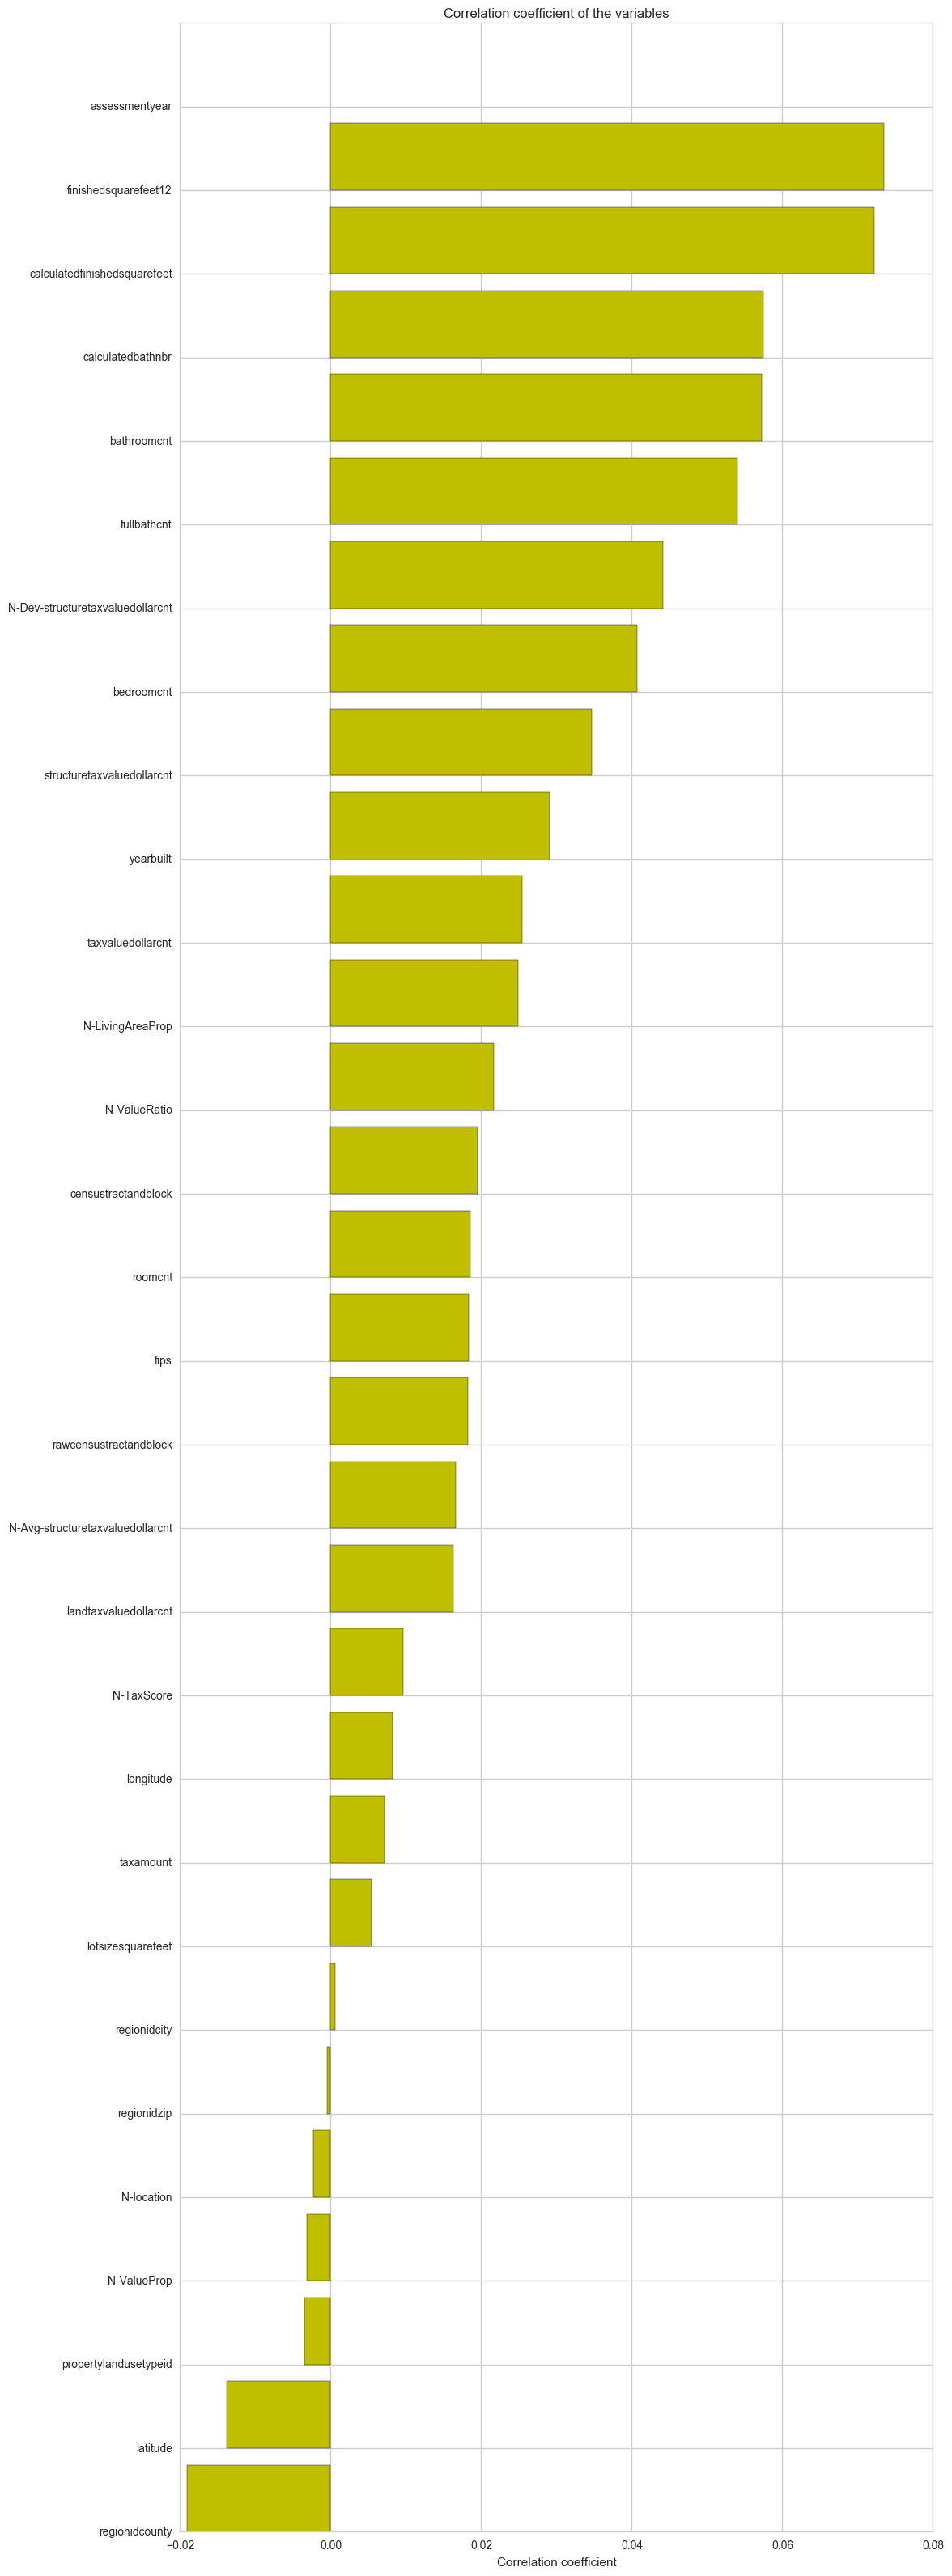

In [16]:
################################################
## Data visualization
################################################
sns.set_style("whitegrid")
x_cols = [col for col in merge_df_new.columns if col not in ['logerror'] if merge_df_new[col].dtype == 'float64'] # select float64 columns
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(merge_df_new[col].values, merge_df_new.logerror.values)[0, 1]) # compute the coefficients with logerror
corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels)) # number of labels
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y') # plot the coefficients for each variables
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
# autolabel(rects)
plt.show()

                          col_labels  corr_values
3                     regionidcounty    -0.019033
5                           latitude    -0.013804
25                      N-ValueRatio     0.021652
24                  N-LivingAreaProp     0.024860
11                 taxvaluedollarcnt     0.025405
17                         yearbuilt     0.029131
14        structuretaxvaluedollarcnt     0.034692
6                         bedroomcnt     0.040753
29  N-Dev-structuretaxvaluedollarcnt     0.044109
18                       fullbathcnt     0.054061
9                        bathroomcnt     0.057267
19                 calculatedbathnbr     0.057491
16      calculatedfinishedsquarefeet     0.072220
21              finishedsquarefeet12     0.073463


F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


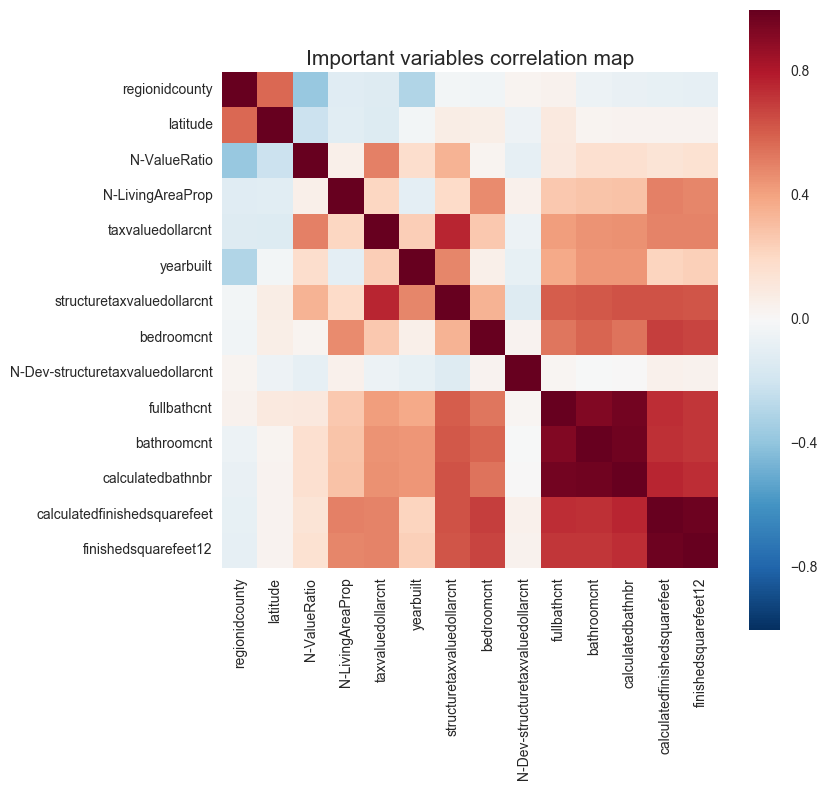

In [17]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
print(corr_df_sel)
cols_to_use = corr_df_sel.col_labels.tolist()
temp_df = merge_df_new[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

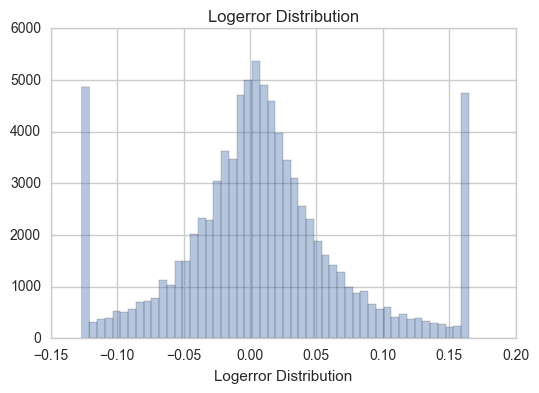

In [18]:
sns.distplot(merge_df_new['logerror'],norm_hist=False, kde=False)# show the number but not the probability
plt.xlabel("Logerror Distribution")
plt.title("Logerror Distribution")
plt.show()


F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


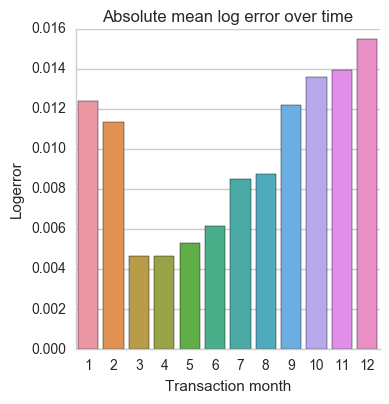

In [19]:
sns.factorplot(x='transaction_month', y='logerror',data=merge_df_new, kind='bar',ci=None)
plt.xlabel('Transaction month')
plt.ylabel('Logerror')
plt.title('Absolute mean log error over time')
plt.show()


3=75th%tile     23987
1=25th%tile     23491
2=50th%tile     21744
4=100th%tile    21053
Name: yearbuild4quantiles, dtype: int64


F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


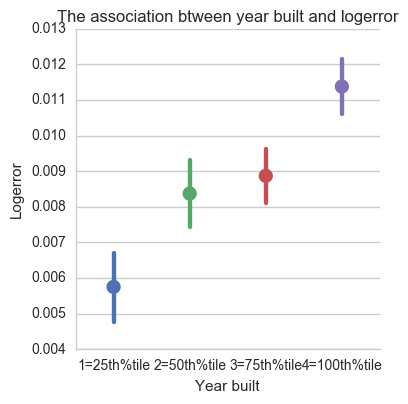

In [20]:
merge_df_new['yearbuild4quantiles'] = pd.qcut(merge_df_new.yearbuilt, 4, labels=["1=25th%tile","2=50th%tile","3=75th%tile","4=100th%tile"])
c1 = merge_df_new['yearbuild4quantiles'].value_counts()
print(c1)
#Change the type of a variable to categorical
merge_df_new['yearbuild4quantiles'] = merge_df_new['yearbuild4quantiles'].astype('category')
sns.factorplot(x='yearbuild4quantiles', y='logerror',data=merge_df_new,hue='yearbuild4quantiles')
plt.xlabel('Year built')
plt.ylabel('Logerror')
plt.title('The association btween year built and logerror')
plt.show()

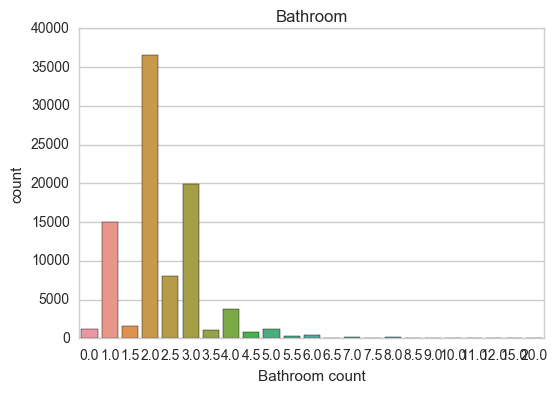

In [21]:
sns.countplot(x='bathroomcnt', data=merge_df_new)
plt.xlabel('Bathroom count')
plt.title('Bathroom')
plt.show()

F:\Anaconda3\envs\gl-env\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


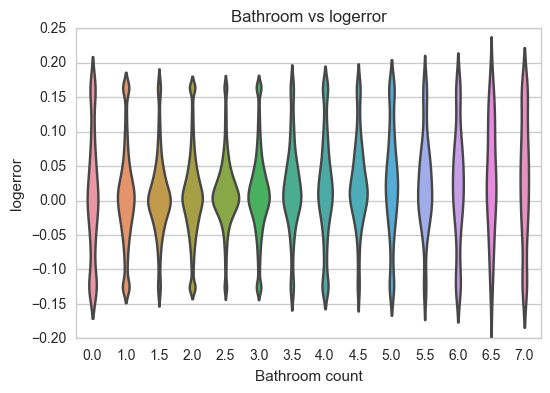

In [22]:
merge_df_new['bathroomcnt'].ix[merge_df_new['bathroomcnt']>7] = 7 #replace the value that greater than ulimit to ulimit
sns.violinplot(x='bathroomcnt',y='logerror', data=merge_df_new,inner=None)
# sns.swarmplot(x='bathroomcnt',y='logerror', data=merge_df_new)
plt.xlabel('Bathroom count')
plt.title('Bathroom vs logerror')
plt.show()

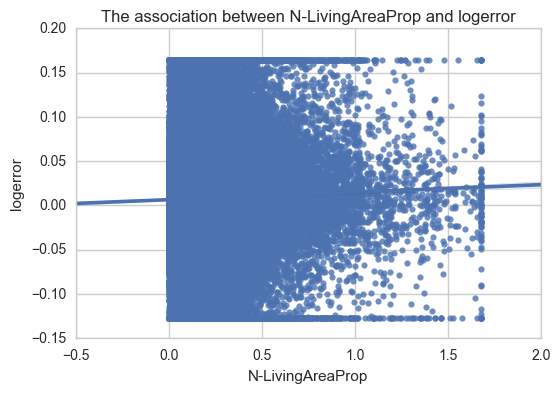

In [23]:
ulimit = np.percentile(merge_df_new['N-LivingAreaProp'].values, 99.9) #select the 99th value of logerror
llimit = np.percentile(merge_df_new['N-LivingAreaProp'].values, 0.1)  ##select the 1st value of logerror
merge_df_new['N-LivingAreaProp'].ix[merge_df_new['N-LivingAreaProp']>ulimit] = ulimit #replace the value that greater than ulimit to ulimit
merge_df_new['N-LivingAreaProp'].ix[merge_df_new['N-LivingAreaProp']<llimit] = llimit ##replace the value that less than llimit to llimit
sns.regplot(x='N-LivingAreaProp',y='logerror', fit_reg=True,  data=merge_df_new)
plt.xlabel("N-LivingAreaProp")
plt.ylabel("logerror")
plt.title("The association between N-LivingAreaProp and logerror")
plt.show()


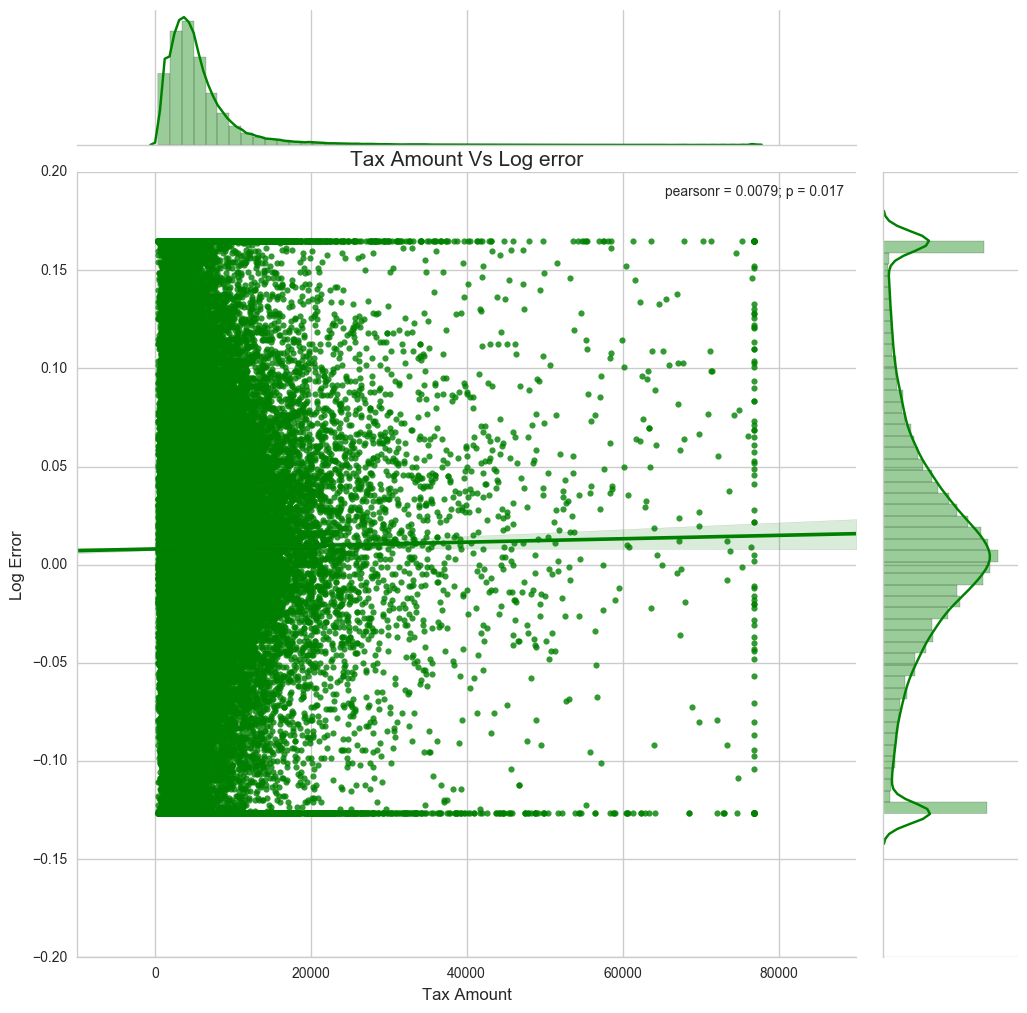

In [24]:
# Examine the correclation between Tax Amount Vs Log error
ulimit = np.percentile(merge_df_new['taxamount'].values, 99.9) #select the 99th value of logerror
llimit = np.percentile(merge_df_new['taxamount'].values, 0.1)  ##select the 1st value of logerror
merge_df_new['taxamount'].ix[merge_df_new['taxamount']>ulimit] = ulimit #replace the value that greater than ulimit to ulimit
merge_df_new['taxamount'].ix[merge_df_new['taxamount']<llimit] = llimit ##replace the value that less than llimit to llimit
plt.figure(figsize=(12,12))
sns.jointplot(x=merge_df_new['taxamount'].values, y=merge_df_new['logerror'].values, size=10, color='g',kind='reg')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

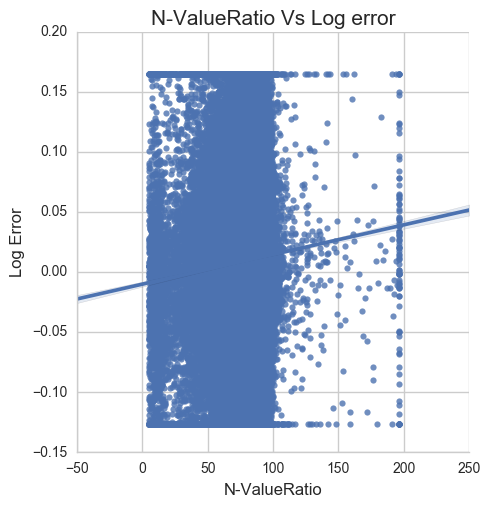

In [28]:
ulimit = np.percentile(merge_df_new['N-ValueRatio'].values, 99.9) #select the 99th value of logerror
llimit = np.percentile(merge_df_new['N-ValueRatio'].values, 0.1)  ##select the 1st value of logerror
merge_df_new['N-ValueRatio'].ix[merge_df_new['N-ValueRatio']>ulimit] = ulimit #replace the value that greater than ulimit to ulimit
merge_df_new['N-ValueRatio'].ix[merge_df_new['N-ValueRatio']<llimit] = llimit ##replace the value that less than llimit to llimit
plt.figure(figsize=(12,12))
sns.lmplot(x='N-ValueRatio', y='logerror',data=merge_df_new)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('N-ValueRatio', fontsize=12)
plt.title("N-ValueRatio Vs Log error", fontsize=15)
plt.show()

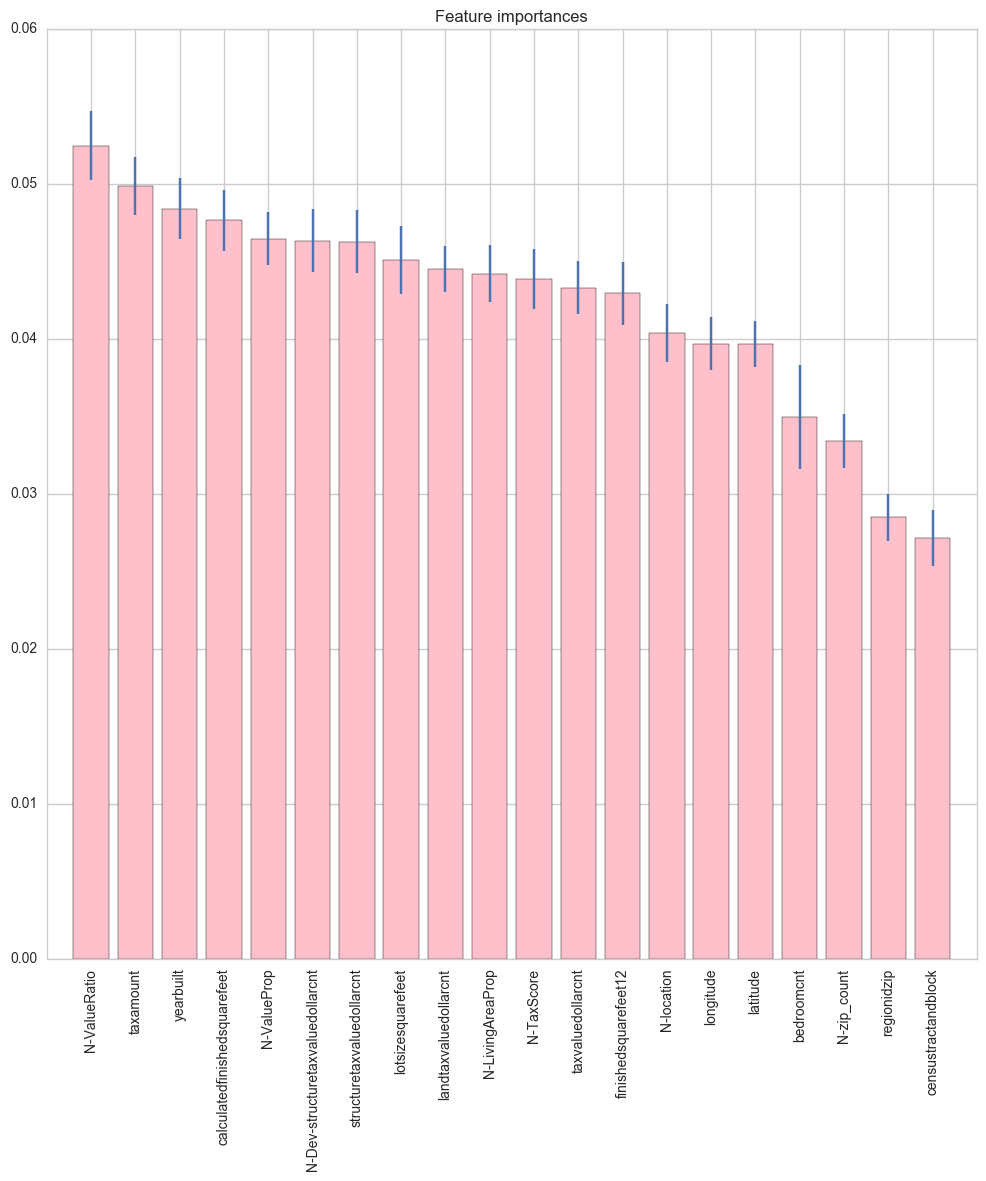

In [109]:
# plot the feature importance
merge_train_y = merge_df_new['logerror'].values
merge_train_X = merge_df_new.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month','propertycountylandusecode','yearbuild4quantiles'], axis=1)
feat_names = merge_train_X.columns.values
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0) # improve model accuracy and avoid over-fitting
model.fit(merge_train_X, merge_train_y) # Build a forest of trees from the training set

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20] # np.argsort returns the indices of the array, [::-1] revert the sequence of the array, [:20] selects the first 20 elements of the array

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="pink", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
##################################modeling####################################################################33
# Using LightGBM to predict
print('Using LightGBM to predict...')
for c, dtype in zip(property_df.columns, property_df.dtypes):
    if dtype == np.float64:
        property_df[c] = property_df[c].astype(np.float32)

x_train = merge_df_new.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month','propertycountylandusecode','yearbuild4quantiles'], axis=1)
y_train = merge_df_new['logerror'].values
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del merge_df_new; gc.collect()

split = 90000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train = x_train.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.3      # feature_fraction (small values => use very different submodels)
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

watchlist = [d_valid]
clf = lgb.train(params, d_train, 1000, watchlist)

del d_train, d_valid; gc.collect()
del x_train, x_valid; gc.collect()

print("Prepare for the prediction ...")
sample = pd.read_csv('sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(property_df, on='parcelid', how='left')

del sample, property_df; gc.collect()

x_test = df_test[train_columns]
del df_test; gc.collect()
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
x_test = x_test.values.astype(np.float32, copy=False)


print("Start prediction ...")
# num_threads > 1 will predict very slow in kernal
clf.reset_parameter({"num_threads":1})
p_test = clf.predict(x_test)

del x_test; gc.collect()

from sklearn.metrics import accuracy_score
accuracy_lightgbm = accuracy_score(p_test,x_test)
from sklearn.metrics import roc_auc_score
auc_lightgbm =  roc_auc_score(x_test,p_test)

print("Start write result ...")
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('lgb_starter.csv', index=False, float_format='%.4f')

